In [6]:
pip uninstall elpigraph-python -y

Found existing installation: elpigraph-python 0.1.0
Uninstalling elpigraph-python-0.1.0:
  Successfully uninstalled elpigraph-python-0.1.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import elpigraph

X = np.genfromtxt('data/tree_data.csv', delimiter=',')[:,:2]
X = np.concatenate(([[1.2,0],
                     [1,1],
                     [0,1]],
                    X))
#X = np.concatenate((np.zeros(25)[None],np.linspace(-1,1,25)[None]),axis=0).T

PointWeights=np.ones(len(X))[None].T
NodePositions=np.array([[-1, 0],
                        [0, -1],
                        [1, 1],
                        [1, .5]])
Edges = np.array([[0,1],
                  [1,2],
                  [2,3],
                  [3,4]])

SquaredX=np.sum(X**2,axis=1,keepdims=1)
FixNodesAtPoints=[[0, 1, 2, 3, 4, 5],[-1,-2,-3,-4,-5]]
#FixNodesAtPoints=[np.arange(20)]
flat_FixNodesAtPoints = [item for sublist in FixNodesAtPoints for item in sublist] #fixed datapoints
if len(set(flat_FixNodesAtPoints)) != len(flat_FixNodesAtPoints):
    raise ValueError('FixNodesAtPoints lists contain duplicate points')
    
FixedNodePositions = np.array([X[inds].mean(axis=0) for inds in FixNodesAtPoints]) #init fixed nodes 
NodePositions=np.concatenate((FixedNodePositions,NodePositions))

Edges = np.concatenate(([[0,1],[1,2]],Edges+len(FixNodesAtPoints)))
SpringLaplacianMatrix = elpigraph.src.core.MakeUniformElasticMatrix(Edges,.1,.1)


ImportError: cannot import name 'PrimitiveElasticGraphEmbedment2' from 'elpigraph.src.core' (/mnt/c/Users/jobac/Desktop/all/git/elpigraph-python/elpigraph/src/core.py)

In [13]:
NumberOfNodes = SpringLaplacianMatrix.shape[0]
fixed_nodes_idx = list(set(range(NumberOfNodes)) - set(move_nodes_idx))

In [10]:
partition, dists = elpigraph.src.core.PartitionData(X,NodePositions,SquaredX=SquaredX,MaxBlockSize=1000000)

# Local data is the data that does not belong to the fixed nodes
# LocalInds is logical index with value true for data points which
# does not correspond to complement of selected set of nodes
# NodeSubSet.
# NodeSubSet is array with numbers of nodes to position optimisation.

#-----Index data and graph into moving nodes and fixed nodes------#
#set of points to fit or keep fixed
flat_FixNodesAtPoints = [item for sublist in FixNodesAtPoints for item in sublist] #fixed datapoints
move_data_idx = [i for i in range(len(X)) if i not in flat_FixNodesAtPoints]
move_nodes_idx = np.arange(len(FixNodesAtPoints),len(NodePositions))
fixed_nodes_idx = np.arange(len(FixNodesAtPoints))
#extract corresponding part of arrays
move_X, move_PointWeights, move_SquaredX, move_NodePositions = X[move_data_idx,:], PointWeights[move_data_idx], SquaredX[move_data_idx], NodePositions[move_nodes_idx]
move_nPoints = len(move_data_idx)
move_partition, move_dists = elpigraph.src.core.PartitionData(move_X,move_NodePositions,SquaredX=move_SquaredX,MaxBlockSize=1000000)
#------Fit-------#

def FitSubGraph2DataGivenPartition(move_X, move_PointWeights, SpringLaplacianMatrix, NodePositions, move_partition, move_nodes_idx):
    """
    Fits moving Subpart of the graph to data while constraining some nodes to remain fixed
    """

    #params 
    NumberOfNodes = len(NodePositions)
    NumberOfNodesSubSet = len(move_nodes_idx)
    NumberOfFixedNodes = NumberOfNodes-NumberOfNodesSubSet
    #new node positions
    NewNodePositions = np.zeros(NodePositions.shape)
    
    #weighted average of moving nodes
    move_NodeClusterCenters, move_NodeClusterRelativeSize = elpigraph.src.core.ComputeWeightedAverage(
        move_X, move_partition, move_PointWeights, NumberOfNodesSubSet
    )

    #SLAUMatrices
    rs = np.zeros((NumberOfNodes))
    rs[move_nodes_idx] = move_NodeClusterRelativeSize.flatten()
    SLAUMatrix  = np.diag(rs)+SpringLaplacianMatrix   
    move_SLAUMatrix = SLAUMatrix[move_nodes_idx][:,move_nodes_idx]
    fixed_SLAUMatrix = SLAUMatrix[move_nodes_idx][:,fixed_nodes_idx]

    #Fit
    RightHandSide = move_NodeClusterRelativeSize * move_NodeClusterCenters
    rhs1 = NodePositions[fixed_nodes_idx]
    RightHandSide -= np.dot(fixed_SLAUMatrix, rhs1)
    move_NewNodePositions = np.linalg.solve(move_SLAUMatrix, RightHandSide)
    
    #Store
    NewNodePositions[fixed_nodes_idx, :] = NodePositions[fixed_nodes_idx, :]
    NewNodePositions[move_nodes_idx, :] = move_NewNodePositions
    
    return NewNodePositions

NodePositions,FitSubGraph2DataGivenPartition(move_X, move_PointWeights, SpringLaplacianMatrix, NodePositions, move_partition, move_nodes_idx)

(array([[-0.26859797,  0.82385726],
        [ 1.16464432,  0.76838245],
        [-1.        ,  0.        ],
        [ 0.        , -1.        ],
        [ 1.        ,  1.        ],
        [ 1.        ,  0.5       ]]),
 array([[-0.26859797,  0.82385726],
        [ 1.16464432,  0.76838245],
        [-0.61406735,  0.67985644],
        [ 0.12207964, -0.70287074],
        [-0.08046392,  0.82926918],
        [ 0.36618261, -0.06886453]]))

Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  495  points and  2  dimensions
BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

Nodes =  4 1||5	0.3224	5	4	1	1	0	0	0.1912	0.1445	0.6492	0.7349	0.0231	0.1081	0.5405	2.7024	0
5 2||6	0.1917	6	5	0	2	0	0	0.1018	0.0598	0.8131	0.8903	0.0265	0.0634	0.3806	2.2837	0
6 2||7	0.1454	7	6	1	2	0	0	0.0904	0.0558	0.834	0.8977	0.0251	0.0299	0.209	1.4628	0
7 2||8	0.1153	8	7	2	2	0	0	0.0739	0.044	0.8645	0.9192	0.0234	0.018	0.1443	1.1547	0
8 2||9	0.0968	9	8	3	2	0	0	0.0554	0.0325	0.8983	0.9403	0.022	0.0194	0.175	1.5746	0
9 2||10	0.082	10	9	4	2	0	0	0.0468	0.0278	0.9141	0.9491	0.0208	0.0143	0.1431	1.4314	0
10 2||11	0.0743	11	10	5	2	0	0	0.0419	0.0274	0.9231	0.9498	0.0184	0.014	0.15

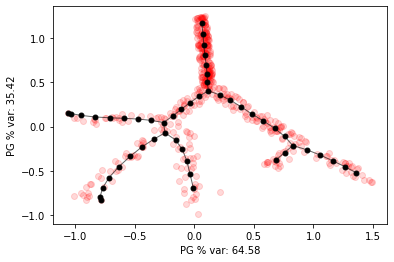

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import elpigraph

X = np.genfromtxt('data/tree_data.csv', delimiter=',')[:,:2]
X = np.concatenate(([[1.2,0],
                     [1,1],
                     [0,1]],
                    X))
#epg=elpigraph.computeElasticPrincipalTree(X,30)
epg1=elpigraph.computeElasticPrincipalTree(X,50,FixNodesAtPoints=[[0],[1]],StoreGraphEvolution=1,Do_PCA=False,verbose=1,
                                           FinalEnergy='Penalized',
                                           alpha=0.01)
elpigraph.plot.PlotPG(X,epg1[0])

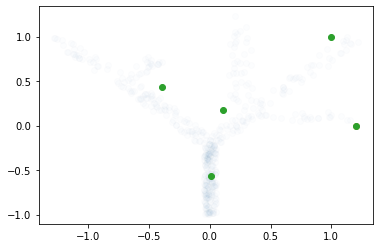

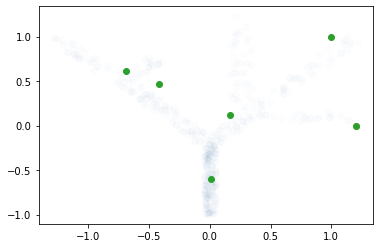

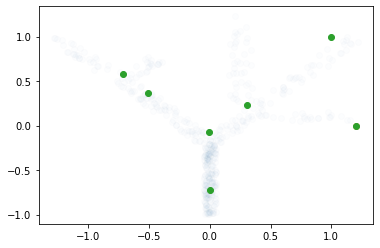

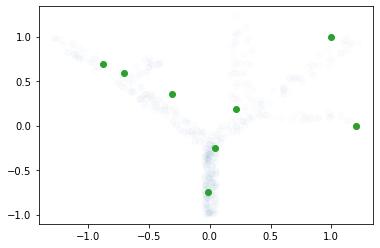

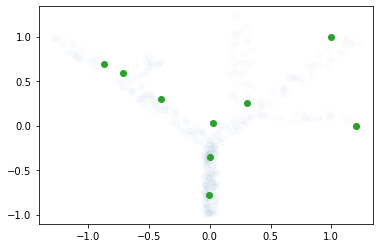

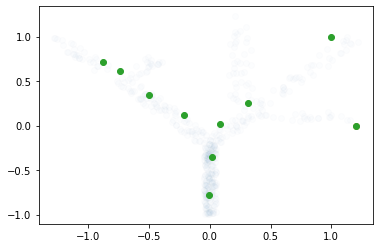

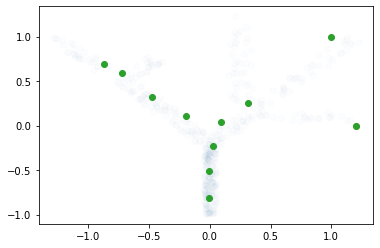

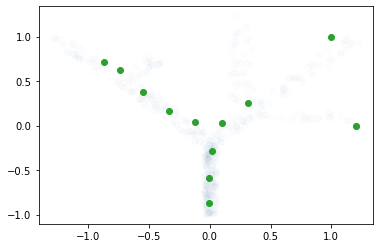

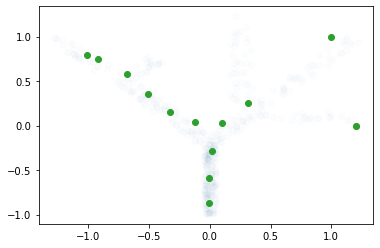

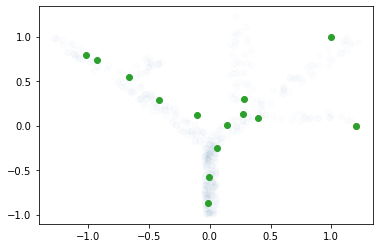

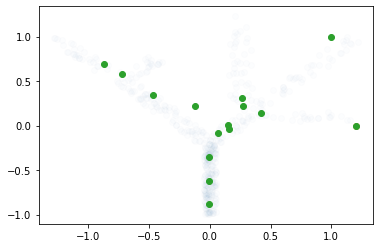

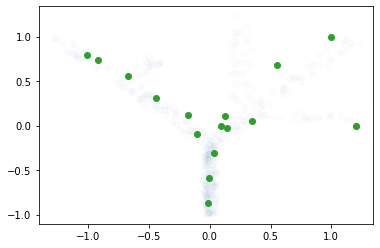

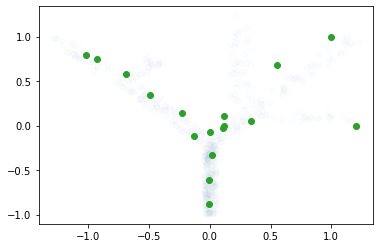

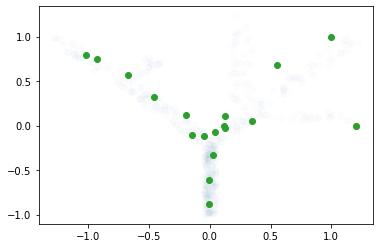

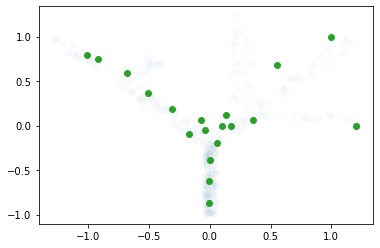

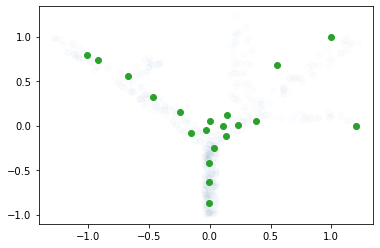

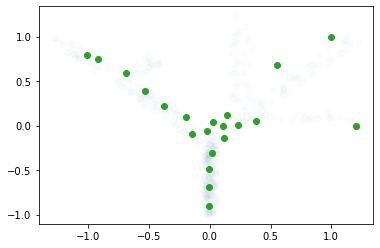

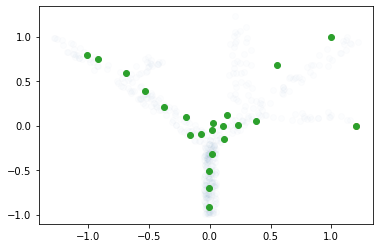

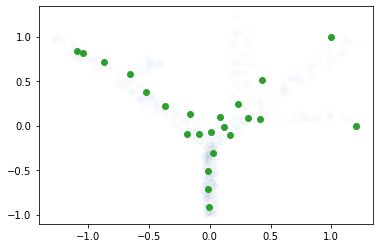

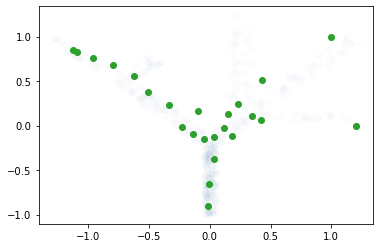

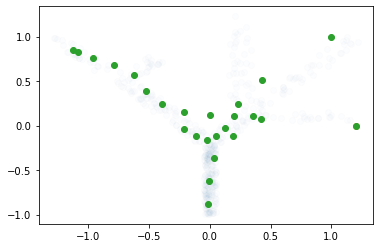

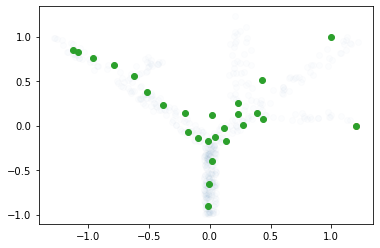

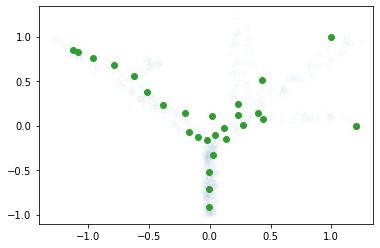

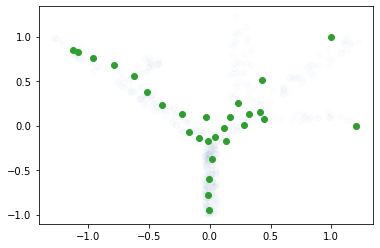

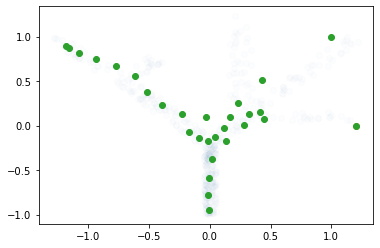

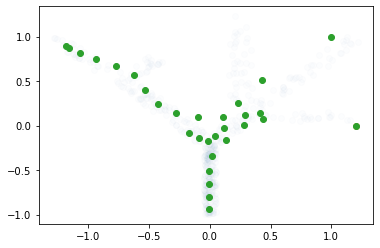

In [12]:
for k,v in epg1[0]['AllNodePositions'].items():
    plt.scatter(*X.T[:2],alpha=.01)
    plt.scatter(*X.T[:2,:1],alpha=.5)
    plt.scatter(*v.T[:2])
    plt.show()

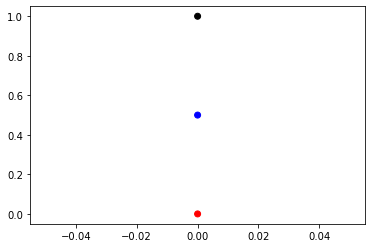

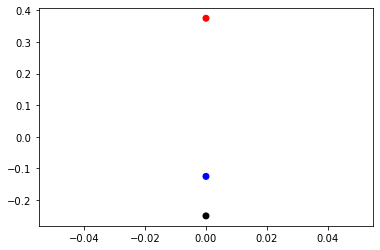

In [170]:
w=np.array([5,1,1])
SLAUMatrix=np.diag(w)
SLAUMatrix[0,1]=SLAUMatrix[1,0]=SLAUMatrix[1,2]=SLAUMatrix[2,1]=SLAUMatrix[2,0]=SLAUMatrix[0,2]=5
NodeClusterCenters = np.array(([0,0],
                               [0,.5],
                               [0,1]))
x=np.linalg.solve(SLAUMatrix,NodeClusterCenters*w[:,None])

plt.scatter(*NodeClusterCenters.T,c=['r','b','k']);plt.show()
plt.scatter(*x.T,c=['r','b','k'])

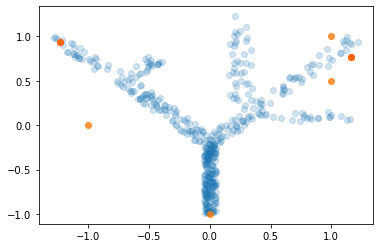

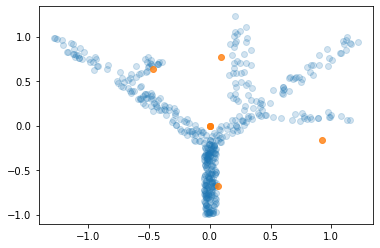

In [90]:
keep = [i for i in range(len(X)) if i not in flat_FixNodesAtPoints] #fitted datapoints

#fitted subset
X_move, SquaredX_move, PointWeights_move = X[keep], SquaredX[keep], PointWeights[keep]
NodePositions_move = NodePositions[len(FixNodesAtPoints):]
SpringLaplacianMatrix_move = SpringLaplacianMatrix[len(FixNodesAtPoints):,len(FixNodesAtPoints):]


plt.scatter(*X.T[:2],alpha=.2)
plt.scatter(*FixedNodePositions.T,c='r')
plt.scatter(*NodePositions.T[:2],alpha=.8)
plt.show()

for i in range(1):
    partition, dists = elpigraph.src.core.PartitionData(X,NodePositions,SquaredX=SquaredX,MaxBlockSize=1000000)

    NumberOfNodes = SpringLaplacianMatrix.shape[0]
    NodeClusterCenters, NodeClusterRelativeSize = elpigraph.src.core.ComputeWeightedAverage(
        X, partition, PointWeights, NumberOfNodes
    )
    SpringLaplacianMatrix[0,1]=SpringLaplacianMatrix[1,0]=10**8
    SLAUMatrix = np.diag(NodeClusterRelativeSize.transpose()[0]) + SpringLaplacianMatrix
    NewNodePositions = np.linalg.solve(
        SLAUMatrix, NodeClusterRelativeSize * NodeClusterCenters
    )

    #NewNodePositions = np.concatenate(
    #    (
    #        NodePositions[:len(FixNodesAtPoints)], #fixed node positions
    #        NewNodePositions #fitted nodes
    #    ))
    NodePositions=NewNodePositions

plt.scatter(*X.T[:2],alpha=.2)
#plt.scatter(*FixedNodePositions.T,c='r')
plt.scatter(*NewNodePositions.T[:2],alpha=.8)
plt.show()